In [1]:
#Working on applying correlations to the data

#Importing the necessary libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from prophet import Prophet
import scipy.stats as stats
import pickle


In [2]:
#Read in data

df_utahpop = pd.read_csv('../Usefull Dataframes/df_utahpop.csv')
df_rmhi = pd.read_csv('../Resources/Real Median Household Income.csv')
mhpu_df = pd.read_csv('../Usefull Dataframes/Median_Home_Prices_Monthly_In_Thousands.csv')
mr_df = pd.read_csv('../Usefull Dataframes/Mortgage rates/MORTGAGE30US.csv')

with open('../Pop vs Build Permits/Resources/permits_df.pkl', 'rb') as f:
    permits_df = pickle.load(f)



    

In [3]:
display(permits_df.head())
display(df_rmhi.head())
display(df_utahpop.head())
display(mhpu_df.head())
display(mr_df.head())

,DATE,UTBP1FH,Month on Month Change,Percent Change,Total Permits
144,2000-01-01,944.0,NaN,NaN,944.0
145,2000-02-01,1082.0,138.0,0.146186,2026.0
146,2000-03-01,1312.0,230.0,0.212569,3338.0
147,2000-04-01,1343.0,31.0,0.023628,4681.0
148,2000-05-01,1363.0,20.0,0.014892,6044.0


,DATE,MEHOINUSUTA672N
0,1984-01-01,58410
1,1985-01-01,61830
2,1986-01-01,63350
3,1987-01-01,61850
4,1988-01-01,59160


,Year,Population,Year on Year Change,Change in Percent
0,2001-01-01,2282415,38208,1.70%
1,2002-01-01,2322002,39587,1.73%
2,2003-01-01,2355755,33753,1.45%
3,2004-01-01,2395448,39693,1.68%
4,2005-01-01,2449105,53657,2.24%


,Date,Home Prices
0,2000-01-01,164.74
1,2000-02-01,164.83
2,2000-03-01,164.97
3,2000-04-01,165.33
4,2000-05-01,166.62


,DATE,MORTGAGE30US
0,4/2/1971,7.33
1,4/9/1971,7.31
2,4/16/1971,7.31
3,4/23/1971,7.31
4,4/30/1971,7.29


In [4]:
#Clean data and prepare them for merge and analysis

#Start with interpolating the annual population year on year change to be a month to month change

#change the 'Year' column to 'Date'
df_utahpop.rename(columns={'Year':'Date'}, inplace=True)

df_utahpop['Date'] = pd.to_datetime(df_utahpop['Date'])

#Interpolate the rows to have monthly instead of annual columns
df_utahpop = df_utahpop.resample('MS', on='Date').first().reset_index()


df_utahpop_yoy = df_utahpop[['Date','Year on Year Change']]

#interpolate the values between each yearly datapoint
df_utahpop_yoy = df_utahpop_yoy.interpolate(method='linear')

df_utahpop_yoy.rename(columns={'Year on Year Change':'Month on Month Change'}, inplace=True)

df_utahpop_yoy.head(25)





,Date,Month on Month Change
0,2001-01-01,38208.000000
1,2001-02-01,38322.916667
2,2001-03-01,38437.833333
3,2001-04-01,38552.750000
4,2001-05-01,38667.666667
5,2001-06-01,38782.583333
6,2001-07-01,38897.500000
7,2001-08-01,39012.416667
8,2001-09-01,39127.333333
9,2001-10-01,39242.250000


In [5]:
#rename the 'DATE' column to 'Date' to match the other dataframes
df_rmhi.rename(columns={'DATE':'Date'}, inplace=True)

#change the 'Date' column to datetime

df_rmhi['Date'] = pd.to_datetime(df_rmhi['Date'])

#Interpolate the rows to have monthly instead of annual columns

df_rmhi = df_rmhi.resample('MS', on='Date').first().reset_index()

df_rmhi = df_rmhi.interpolate(method='linear')

#Change the 'MEHOIUSUTA672N' column to 'Real Median Household Income'
df_rmhi.rename(columns={'MEHOINUSUTA672N':'Real Median Household Income'}, inplace=True)

#Change the units in the 'Real Median Household Income' column to have a dollar sign and have a comma for the thousands
df_rmhi['Real Median Household Income'] = df_rmhi['Real Median Household Income'].map('${:,.0f}'.format)



df_rmhi.head(25)

,Date,Real Median Household Income
0,1984-01-01,"$58,410"
1,1984-02-01,"$58,695"
2,1984-03-01,"$58,980"
3,1984-04-01,"$59,265"
4,1984-05-01,"$59,550"
5,1984-06-01,"$59,835"
6,1984-07-01,"$60,120"
7,1984-08-01,"$60,405"
8,1984-09-01,"$60,690"
9,1984-10-01,"$60,975"


In [6]:
#rename the 'DATE' column to 'Date' to match the other dataframes
mr_df.rename(columns={'DATE':'Date'}, inplace=True)

#change the 'Date' column to datetime

mr_df['Date'] = pd.to_datetime(mr_df['Date'])

#Interpolate the rows to have monthly entries on the first of each month instead of weekly columns
mr_df = mr_df.resample('MS', on='Date').first().reset_index()

mr_df = mr_df.interpolate(method='linear')

#Change the 'MORTGAGE30US' column to '30-Year Mortgage Interest Rate'
mr_df.rename(columns={'MORTGAGE30US':'30-Year Mortgage Interest Rate'}, inplace=True)

 



mr_df.head(25)

,Date,30-Year Mortgage Interest Rate
0,1971-04-01,7.33
1,1971-05-01,7.38
2,1971-06-01,7.52
3,1971-07-01,7.54
4,1971-08-01,7.66
5,1971-09-01,7.71
6,1971-10-01,7.67
7,1971-11-01,7.59
8,1971-12-01,7.49
9,1972-01-01,7.46


In [7]:
# Slice mhpu_df to only include dates starting from 2001-01-01
mhpu_df = mhpu_df[mhpu_df['Date'] >= '2001-01-01']

#convert the 'Date' column to datetime
mhpu_df['Date'] = pd.to_datetime(mhpu_df['Date'])

mhpu_df.head()


,Date,Home Prices
12,2001-01-01,172.53
13,2001-02-01,172.80
14,2001-03-01,172.97
15,2001-04-01,173.14
16,2001-05-01,173.24


In [8]:
#Change the 'DATE column to 'Date'
permits_df.rename(columns={'DATE':'Date'}, inplace=True)

# Slice permits_df to only include dates starting from 2001-01-01
permits_df = permits_df[permits_df['Date'] >= '2001-01-01']

#convert the 'Date' column to datetime
permits_df['Date'] = pd.to_datetime(permits_df['Date'])

cln_permits_df = permits_df[['Date','Total Permits']]

cln_permits_df.head()



,Date,Total Permits
156,2001-01-01,14671.0
157,2001-02-01,15632.0
158,2001-03-01,16983.0
159,2001-04-01,18191.0
160,2001-05-01,19586.0


In [9]:
# Merge the dataframes on the 'Date' column
merged_df = pd.merge(df_utahpop_yoy, mhpu_df, on='Date')
merged_df = pd.merge(merged_df, cln_permits_df, on='Date')
merged_df = pd.merge(merged_df, df_rmhi, on='Date')
merged_df = pd.merge(merged_df, mr_df, on='Date')
merged_df.set_index('Date', inplace=True)


merged_df

,Month on Month Change,Home Prices,Total Permits,Real Median Household Income,30-Year Mortgage Interest Rate
Date,,,,,
2001-01-01,38208.000000,172.53,14671.0,"$74,400",7.07
2001-02-01,38322.916667,172.80,15632.0,"$74,390",7.09
2001-03-01,38437.833333,172.97,16983.0,"$74,380",7.03
2001-04-01,38552.750000,173.14,18191.0,"$74,370",7.01
2001-05-01,38667.666667,173.24,19586.0,"$74,360",7.14
...,...,...,...,...,...
2021-09-01,46234.000000,462.03,330337.0,"$95,370",2.87
2021-10-01,45097.250000,466.85,332020.0,"$95,478",2.99
2021-11-01,43960.500000,471.53,333796.0,"$95,585",3.09


In [10]:
merged_df['Lagged Total Permits'] = merged_df['Total Permits'].shift(2)
merged_df['Lagged Home Prices'] = merged_df['Home Prices'].shift(2)
merged_df['Lagged Real Median Household Income'] = merged_df['Real Median Household Income'].shift(12)

merged_df.head(25)

,Month on Month Change,Home Prices,Total Permits,Real Median Household Income,30-Year Mortgage Interest Rate,Lagged Total Permits,Lagged Home Prices,Lagged Real Median Household Income
Date,,,,,,,,
2001-01-01,38208.000000,172.53,14671.0,"$74,400",7.07,NaN,NaN,None
2001-02-01,38322.916667,172.80,15632.0,"$74,390",7.09,NaN,NaN,None
2001-03-01,38437.833333,172.97,16983.0,"$74,380",7.03,14671.0,172.53,None
2001-04-01,38552.750000,173.14,18191.0,"$74,370",7.01,15632.0,172.80,None
2001-05-01,38667.666667,173.24,19586.0,"$74,360",7.14,16983.0,172.97,None
2001-06-01,38782.583333,173.40,20926.0,"$74,350",7.24,18191.0,173.14,None
2001-07-01,38897.500000,173.54,22226.0,"$74,340",7.19,19586.0,173.24,None
2001-08-01,39012.416667,173.80,23669.0,"$74,330",7.00,20926.0,173.40,None
2001-09-01,39127.333333,174.05,24817.0,"$74,320",6.89,22226.0,173.54,None


In [11]:
#change the Real Median Household Income and the Lagged Real Median Household Income column to a float
merged_df['Real Median Household Income'] = merged_df['Real Median Household Income'].str.replace(',', '').str.replace('$', '').astype(float)
merged_df['Lagged Real Median Household Income'] = merged_df['Lagged Real Median Household Income'].str.replace(',', '').str.replace('$', '').astype(float)


merged_df.corr()

,Month on Month Change,Home Prices,Total Permits,Real Median Household Income,30-Year Mortgage Interest Rate,Lagged Total Permits,Lagged Home Prices,Lagged Real Median Household Income
Month on Month Change,1.000000,0.325746,0.354026,0.336524,-0.086505,0.340872,0.325572,0.439909
Home Prices,0.325746,1.000000,0.856864,0.914838,-0.629452,0.854324,0.999071,0.912104
Total Permits,0.354026,0.856864,1.000000,0.778959,-0.865635,0.999922,0.860817,0.761752
Real Median Household Income,0.336524,0.914838,0.778959,1.000000,-0.537467,0.775582,0.916135,0.922856
30-Year Mortgage Interest Rate,-0.086505,-0.629452,-0.865635,-0.537467,1.000000,-0.863442,-0.626312,-0.506461
Lagged Total Permits,0.340872,0.854324,0.999922,0.775582,-0.863442,1.000000,0.857363,0.756678
Lagged Home Prices,0.325572,0.999071,0.860817,0.916135,-0.626312,0.857363,1.000000,0.915600
Lagged Real Median Household Income,0.439909,0.912104,0.761752,0.922856,-0.506461,0.756678,0.915600,1.000000


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>], dtype=object)

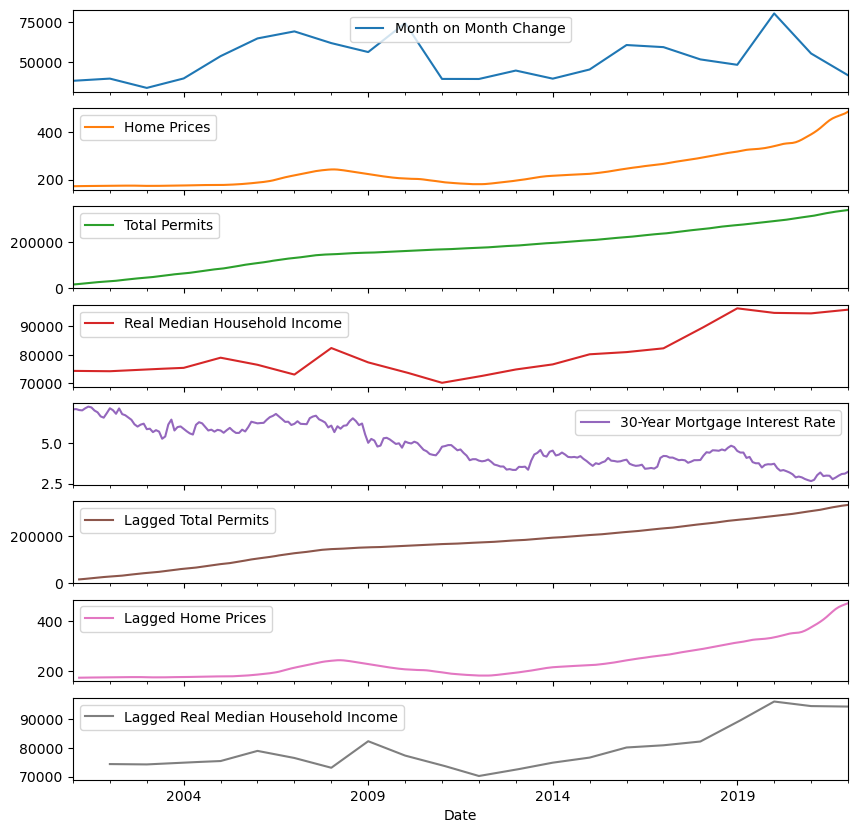

In [12]:
#plot = merged_df.plot(subplots=True, figsize=(10, 10))
merged_df.plot(subplots=True, figsize=(10, 10))

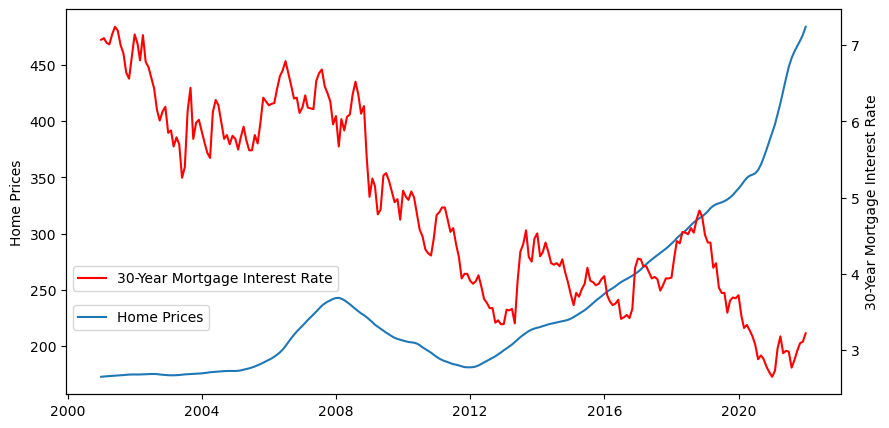

In [27]:

# Create a plot that compares Home Prices and Interest Rates
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot Home Prices on the left y-axis
ax1.plot(merged_df['Home Prices'], label='Home Prices')
ax1.set_ylabel('Home Prices')

# Create a second y-axis for 30-Year Mortgage Interest Rate
ax2 = ax1.twinx()
ax2.plot(merged_df['30-Year Mortgage Interest Rate'], color='red', label='30-Year Mortgage Interest Rate')
ax2.set_ylabel('30-Year Mortgage Interest Rate')

# Display the legends and show the plot
ax1.legend(loc='upper left', bbox_to_anchor=(0, 0.25))
ax2.legend(loc='lower left', bbox_to_anchor=(0, 0.25))

#export the plot as a png file
fig.savefig('../../../Best Home Prices vs Interest Rates.png')

plt.show()


